# Heart Disease Prediction

## Import libraries

In [121]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import warnings
import time
import sklearn
import itertools
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix, recall_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.impute import KNNImputer
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA, KernelPCA
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.optimizers import SGD, Adam

In [19]:
np.random.seed(0)

# 1. Dataset Introduction

## 1.1 Import Dataset
We import our dataset into _pandas.DataFrame_, which is shown above:

In [20]:
df = pd.read_csv('processed.cleveland.csv', sep=',')
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,1,145,233,1,2,150,0,2.3,3,0,6,0
1,67,1,4,160,286,0,2,108,1,1.5,2,3,3,2
2,67,1,4,120,229,0,2,129,1,2.6,2,2,7,1
3,37,1,3,130,250,0,0,187,0,3.5,3,0,3,0
4,41,0,2,130,204,0,2,172,0,1.4,1,0,3,0


## 1.2 Dataset Description
We use Heart Disease UCI dataset (link: https://archive.ics.uci.edu/ml/datasets/Heart+Disease) for this project. This dataset contains 76 attributes, but all published experiments refer to using a subset of 14 of them. Brief description of its attributes are shown below:
1. age: age in years
2. sex: sex (1 = male; 0 = female)
3. cp: chest pain type
        -- Value 1: typical angina
        -- Value 2: atypical angina
        -- Value 3: non-anginal pain
        -- Value 4: asymptomatic
4. trestbps: resting blood pressure (in mm Hg on admission to the hospital)
5. chol: serum cholestoral in mg/dl
6. fbs: (fasting blood sugar > 120 mg/dl)  (1 = true; 0 = false)
7. restecg: resting electrocardiographic results
        -- Value 0: normal
        -- Value 1: having ST-T wave abnormality (T wave inversions and/or ST 
                    elevation or depression of > 0.05 mV)
        -- Value 2: showing probable or definite left ventricular hypertrophy
                    by Estes' criteria
8. thalach: maximum heart rate achieved
9. exang: exercise induced angina (1 = yes; 0 = no)
10. oldpeak = ST depression induced by exercise relative to rest
11. slope: the slope of the peak exercise ST segment
        -- Value 1: upsloping
        -- Value 2: flat
        -- Value 3: downsloping
12. ca: number of major vessels (0-3) colored by flourosopy
13. thal: 3 = normal; 6 = fixed defect; 7 = reversable defect
14. target: diagnosis of heart disease (angiographic disease status)
        -- Value 0: < 50% diameter narrowing
        -- Value 1: > 50% diameter narrowing
With the help of this dataset, we aim to predict the presence of heart disease with these 13 features for the patients. Our goal is to use the machine learning models to help predict the variable _target_.

The dataset has 14 columns - 13 independent variables and 1 dependent variable _target_. There are 303 entries, corresponding to 303 patients in the record.
( _ca_ and _thal_ are _object_, so we should transform to _int_ or _float_ later.)

In [21]:
df.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int64  
 1   sex       303 non-null    int64  
 2   cp        303 non-null    int64  
 3   trestbps  303 non-null    int64  
 4   chol      303 non-null    int64  
 5   fbs       303 non-null    int64  
 6   restecg   303 non-null    int64  
 7   thalach   303 non-null    int64  
 8   exang     303 non-null    int64  
 9   oldpeak   303 non-null    float64
 10  slope     303 non-null    int64  
 11  ca        303 non-null    object 
 12  thal      303 non-null    object 
 13  target    303 non-null    int64  
dtypes: float64(1), int64(11), object(2)
memory usage: 33.3+ KB


In [22]:
df.dtypes

age           int64
sex           int64
cp            int64
trestbps      int64
chol          int64
fbs           int64
restecg       int64
thalach       int64
exang         int64
oldpeak     float64
slope         int64
ca           object
thal         object
target        int64
dtype: object

## 1.3 Imputing Missing Values
* _ca_ has 4 missing values, _thal_ has 2 missing values
* Impute them with KNNImputer

In [23]:
def bar_plot_unknown(df):
    '''
    Visualize the number of unknown values in different features
        
    Parameters
    
        df: DataFrame
    '''
    columns= list()
    values = list()
    for i in df.columns:
        if type(df[i][0]) is str:
            count = df[df[i]=='?']['target'].count()
            if count:
                columns.append(i)
                values.append(count)
    plt.figure(figsize=(8,6))
    sns.barplot(x = columns,y = values, palette="Blues_d")
    plt.title('Number of unknown values in different features')
    plt.tight_layout()

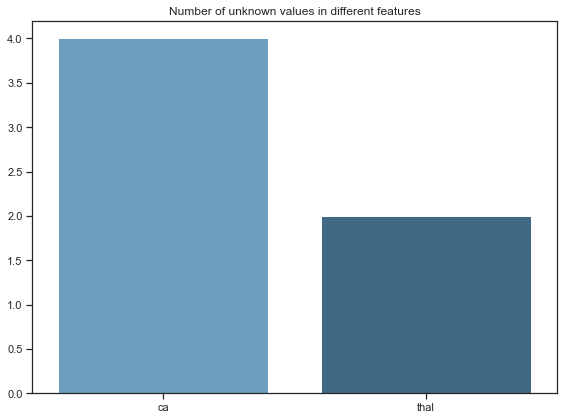

In [24]:
# Missing values
bar_plot_unknown(df)

In [25]:
df = df.replace('?', np.NaN)
imputer = KNNImputer(n_neighbors=5, weights="distance") 
df_imputed = imputer.fit_transform(df)
df_imputed = pd.DataFrame(df_imputed, columns=df.columns)
df = df_imputed
df

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,0.0
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,2.0
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1.0
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0.0
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
298,45.0,1.0,1.0,110.0,264.0,0.0,0.0,132.0,0.0,1.2,2.0,0.0,7.0,1.0
299,68.0,1.0,4.0,144.0,193.0,1.0,0.0,141.0,0.0,3.4,2.0,2.0,7.0,2.0
300,57.0,1.0,4.0,130.0,131.0,0.0,0.0,115.0,1.0,1.2,2.0,1.0,7.0,3.0
301,57.0,0.0,2.0,130.0,236.0,0.0,2.0,174.0,0.0,0.0,2.0,1.0,3.0,1.0


## 1.4 Preprocessing
* Make the category of _thal_ 1, 2, 3
* Transform the task into a binary classification

In [26]:
def process_data(df):
    df["ca"] = df["ca"].astype(int)
    df["thal"] = df["thal"].astype(int)
    df.loc[df["thal"] == 3, "thal"] = 1
    df.loc[df["thal"] == 6, "thal"] = 2
    df.loc[df["thal"] == 7, "thal"] = 3
    df.loc[df["target"] == 2, "target"] = 1
    df.loc[df["target"] == 3, "target"] = 1
    df.loc[df["target"] == 4, "target"] = 1
    return df

In [27]:
df = process_data(df)
df

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0,2,0.0
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3,1,1.0
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2,3,1.0
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0,1,0.0
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0,1,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
298,45.0,1.0,1.0,110.0,264.0,0.0,0.0,132.0,0.0,1.2,2.0,0,3,1.0
299,68.0,1.0,4.0,144.0,193.0,1.0,0.0,141.0,0.0,3.4,2.0,2,3,1.0
300,57.0,1.0,4.0,130.0,131.0,0.0,0.0,115.0,1.0,1.2,2.0,1,3,1.0
301,57.0,0.0,2.0,130.0,236.0,0.0,2.0,174.0,0.0,0.0,2.0,1,1,1.0


In [28]:
print(df.shape)
df.describe()

(303, 14)


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
count,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000
mean,54.438944,0.679868,3.158416,131.689769,246.693069,0.148515,0.990099,149.607261,0.326733,1.039604,1.600660,0.666667,1.844884,0.458746
std,9.038662,0.467299,0.960126,17.599748,51.776918,0.356198,0.994971,22.875003,0.469794,1.161075,0.616226,0.933790,0.972655,0.499120
min,29.000000,0.000000,1.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000
25%,48.000000,0.000000,3.000000,120.000000,211.000000,0.000000,0.000000,133.500000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000
50%,56.000000,1.000000,3.000000,130.000000,241.000000,0.000000,1.000000,153.000000,0.000000,0.800000,2.000000,0.000000,1.000000,0.000000
75%,61.000000,1.000000,4.000000,140.000000,275.000000,0.000000,2.000000,166.000000,1.000000,1.600000,2.000000,1.000000,3.000000,1.000000
max,77.000000,1.000000,4.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.200000,3.000000,3.000000,5.000000,1.000000


The barplot shows that the distribution of labels are roughly balanced:

In [29]:
def bar_plot_label(df):
    '''
    Visualize the distribution of labels
    
    Parameters
    
        df: DataFrame
    '''
    label = df['target'].value_counts().index
    num = df['target'].value_counts().values
    plt.figure(figsize=(10,6))
    plt.title('Distribution of labels')
    print(df["target"].value_counts())
    sns.barplot(x = label,y = num, palette="Blues_d")

0.0    164
1.0    139
Name: target, dtype: int64


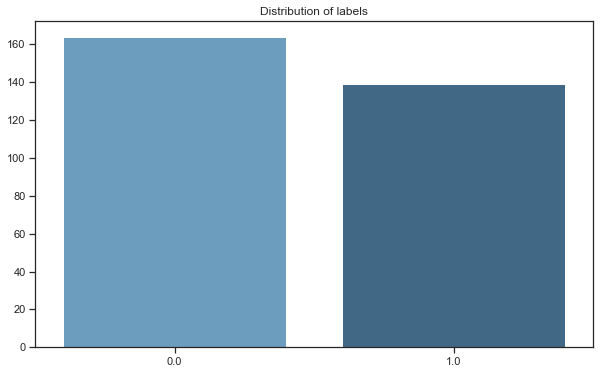

In [30]:
bar_plot_label(df)

## 1.5 Heatmap
* Draw a heatmap for the correlation between all the variables
* The correlation matrix shows that our dependent variable _target_ have correlation with _cp_, _exang_, _oldpeak_, _ca_ and _thal_
* All the independent variables seem not to have much correlation with each other, except the last a few columns

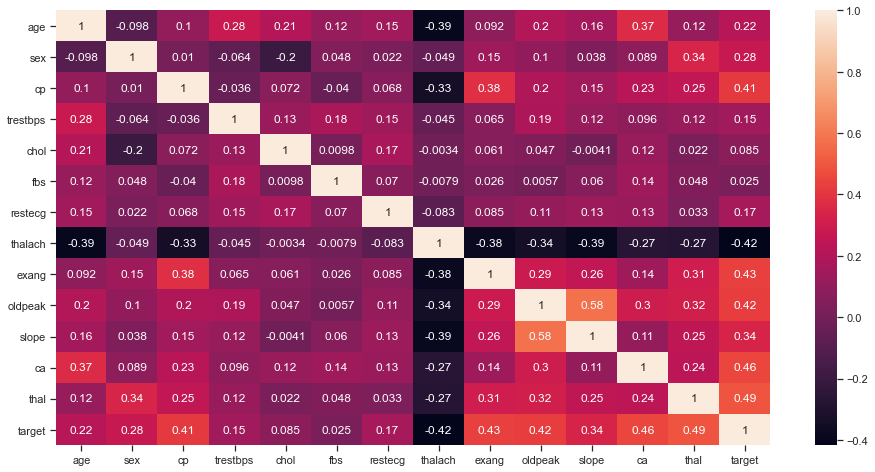

In [31]:
plt.figure(figsize = (16, 8))

correlation_matrix = df.corr()
sns.heatmap(correlation_matrix, annot = True)
plt.show()

## 1.6 Pairplot
* The pairplot shows the relationship between the selected variables _cp_, _exang_, _oldpeak_, _ca_ and _thal_ and target variable _target_
* We can see that the variables _cp_, _exang_, _oldpeak_, _ca_ and _thal_ has not much collinearity with each other
* All these variables seem to have different distribution when target = 0 or 1

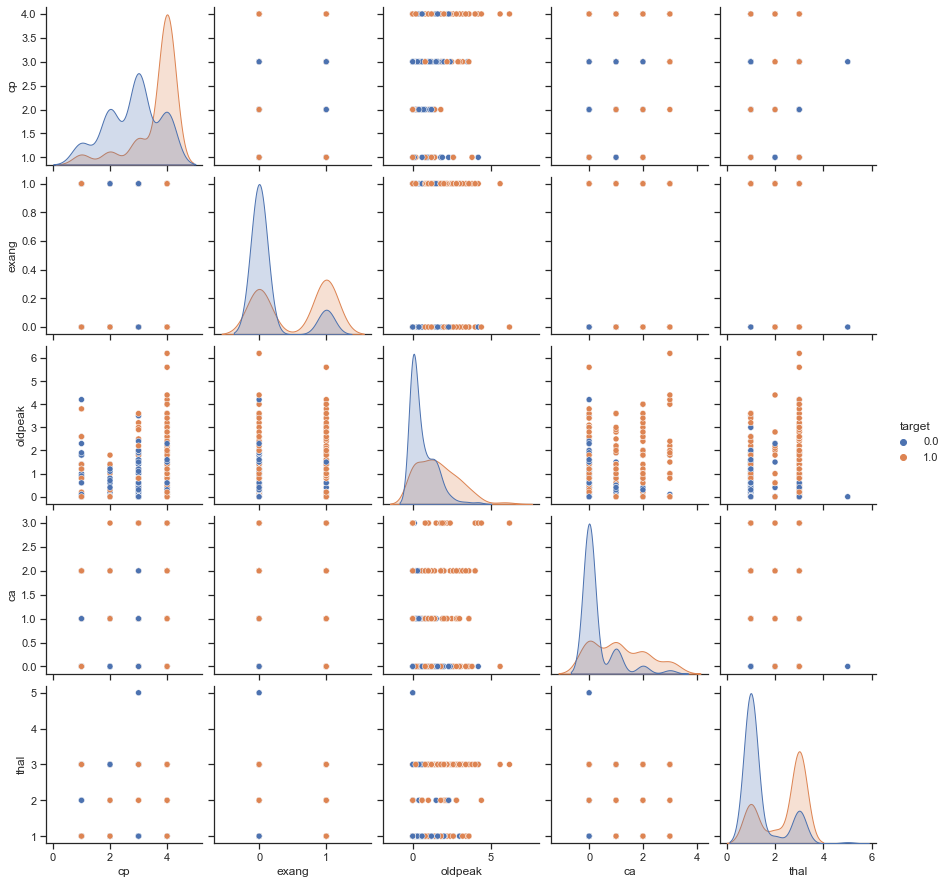

In [32]:
df_subset = df[["target","cp", "exang", "oldpeak", "ca", "thal"]]

sns.set_theme(style="ticks")
sns.pairplot(df_subset, hue="target")

## 1.7 Distplot
* _seaborn.distplot_ shows the histogram and kernel density estimation plot of the variables
* We can see that the numerical variables are all roughly normal distributed
* The categorical variables follow binomial distribution or multinomial distribution

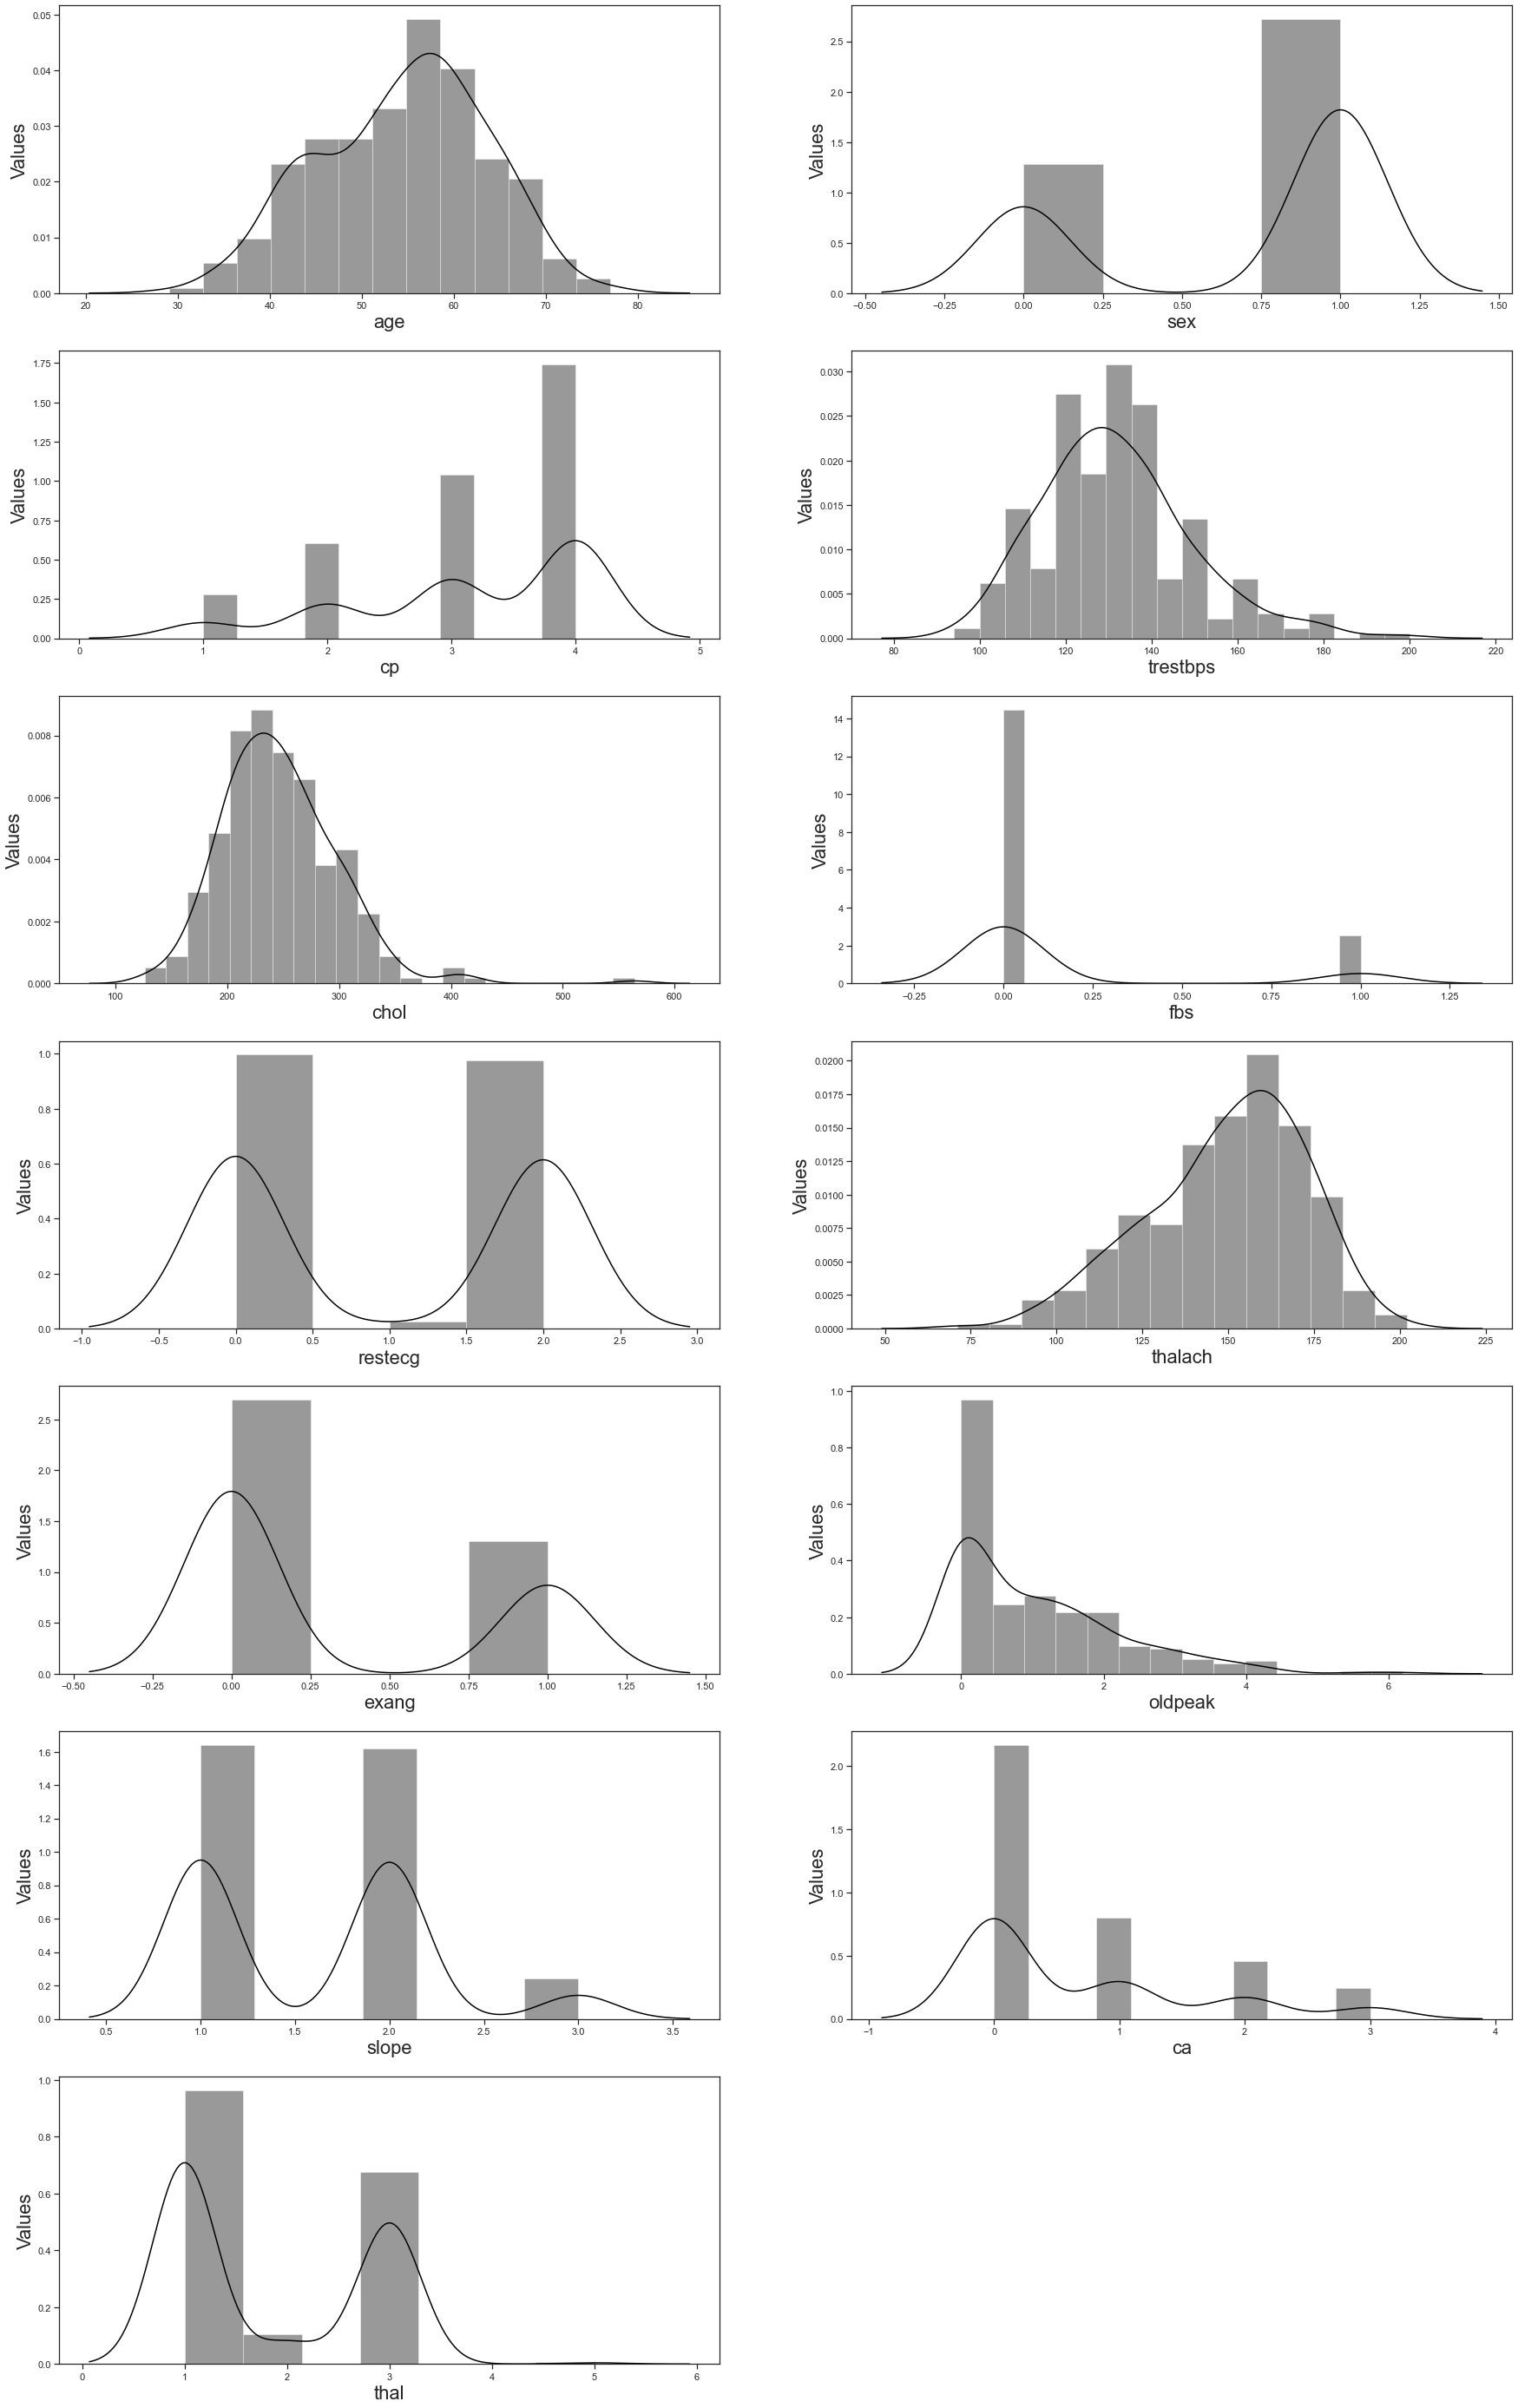

In [33]:
warnings.filterwarnings('ignore')
 
plt.figure(figsize=(30,50))
plot_num = 1

for column in df:
    if plot_num < 14:
        ax = plt.subplot(7, 2, plot_num)
        sns.distplot(df[column], color="black")
        plt.xlabel(column, fontsize=22)
        plt.ylabel('Values', fontsize=22)
    plot_num += 1
plt.show()

# 2. Supervised Learning Tasks
* For supervised learning tasks, we firstly split the training set and testing set, and then standardize the data to mean 0 and variance 1
* We use 4 different machine learning algorithms, Support Vector Machine, Decision Tree, Random Forest and Neuron Network, to train a model and try to make prediction on _target_

## Preprocessing and Train Test split
* The training size is 0.8, testing size is 0.2

In [34]:
X = df.drop(["target"], axis = 1)
y = df.target
X

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0,2
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3,1
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2,3
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0,1
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
298,45.0,1.0,1.0,110.0,264.0,0.0,0.0,132.0,0.0,1.2,2.0,0,3
299,68.0,1.0,4.0,144.0,193.0,1.0,0.0,141.0,0.0,3.4,2.0,2,3
300,57.0,1.0,4.0,130.0,131.0,0.0,0.0,115.0,1.0,1.2,2.0,1,3
301,57.0,0.0,2.0,130.0,236.0,0.0,2.0,174.0,0.0,0.0,2.0,1,1


In [35]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler().fit(X)
X = scaler.transform(X)
X

array([[ 0.94872647,  0.68620244, -2.25177456, ...,  2.27457861,
        -0.71511706,  0.15974017],
       [ 1.39200191,  0.68620244,  0.87798549, ...,  0.64911323,
         2.5029097 , -0.87007413],
       [ 1.39200191,  0.68620244,  0.87798549, ...,  0.64911323,
         1.43023411,  1.18955448],
       ...,
       [ 0.28381332,  0.68620244,  0.87798549, ...,  0.64911323,
         0.35755853,  1.18955448],
       [ 0.28381332, -1.4572959 , -1.20852121, ...,  0.64911323,
         0.35755853, -0.87007413],
       [-1.82174501,  0.68620244, -0.16526786, ..., -0.97635214,
        -0.71511706, -0.87007413]])

In [36]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 1)
print('Train set:', X_train.shape, y_train.shape)
print('Test set:', X_test.shape, y_test.shape)

Train set: (242, 13) (242,)
Test set: (61, 13) (61,)


## 2.1 Support Vector Machine
* We use _GridSearchCV_ to exhaustively search over specified parameter values for the estimator
* Compare the performance of linear kernel and rbf kernel by their accuracy

### Linear Kernel
* SVM with linear kernel seems to overfit on the training set, hence not doing well on testing set
* Best parameters: C = 10, Accuracy: 81.97% 

In [73]:
param_grid = {
    'kernel': ['linear'],
    'C': [1, 10, 100, 1000]
}

scorer = "accuracy"

svm_clf = SVC()
svm_grid = RandomizedSearchCV(estimator = svm_clf, param_distributions = param_grid, cv = 5, scoring = scorer, n_jobs = -1)
svm_grid.fit(X_train, y_train)

RandomizedSearchCV(cv=5, estimator=SVC(), n_jobs=-1,
                   param_distributions={'C': [1, 10, 100, 1000],
                                        'kernel': ['linear']},
                   scoring='accuracy')

In [74]:
print("The best parameters are: ", svm_grid.best_params_)
print("Training accuracy: ", svm_grid.score(X_train, y_train))
print("Cross Validation accuracy: ", svm_grid.best_score_)
print("Testing accuracy: ", svm_grid.score(X_test, y_test))

The best parameters are:  {'kernel': 'linear', 'C': 10}
Training accuracy:  0.859504132231405
Cross Validation accuracy:  0.8427721088435375
Testing accuracy:  0.819672131147541


### RBF Kernel
* SVM with RBF kernel seems to perform well on both the training set and testing set
* Best parameters: gamma = 0.001, C = 100, Accuracy: 85.24%, superseding the linear kernel a bit

In [75]:
param_grid = {
    'kernel': ['rbf'], 
    'gamma': [1e-3, 1e-4],
    'C': [1, 10, 100, 1000]
}

scorer = "accuracy"

svm_clf = SVC()
svm_grid = RandomizedSearchCV(estimator = svm_clf, param_distributions = param_grid, cv = 5, scoring = scorer, n_jobs = -1)
svm_grid.fit(X_train, y_train)

RandomizedSearchCV(cv=5, estimator=SVC(), n_jobs=-1,
                   param_distributions={'C': [1, 10, 100, 1000],
                                        'gamma': [0.001, 0.0001],
                                        'kernel': ['rbf']},
                   scoring='accuracy')

In [76]:
print("The best parameters are: ", svm_grid.best_params_)
print("Training accuracy: ", svm_grid.score(X_train, y_train))
print("Cross Validation accuracy: ", svm_grid.best_score_)
print("Testing accuracy: ", svm_grid.score(X_test, y_test))

The best parameters are:  {'kernel': 'rbf', 'gamma': 0.001, 'C': 100}
Training accuracy:  0.8636363636363636
Cross Validation accuracy:  0.8345238095238094
Testing accuracy:  0.8524590163934426


### Draw Confusion Matrix
* Confusion matrix shows the accuracy of a classification: the count of true negatives is C[0,0], false negatives is C[1,0], true positives is C[1,1] and false positives is C[0,1]
* The false negatives and false positives seems balanced

In [55]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[21  6]
 [ 5 29]]


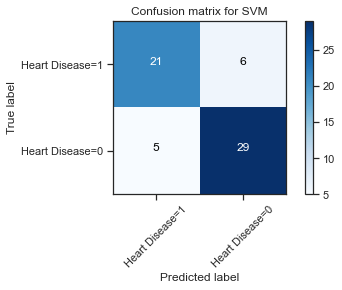

In [56]:
# Compute confusion matrix
LR_cnf_matrix = confusion_matrix(y_test, svm_grid.predict(X_test), labels=[1,0])
np.set_printoptions(precision=2)


# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(LR_cnf_matrix, classes=['Heart Disease=1','Heart Disease=0'], normalize= False, title='Confusion matrix for SVM')

## 2.2 Decision Tree Classifier
* We use _GridSearchCV_ to exhaustively search over specified parameter values for the estimator
* Plot the decision tree and feature importances to visualize the tree architecture
* Based on pre-pruning and post-pruning, we improve the accuracy on the testing set and computation complexity

### Pre-pruning techiniques
* Pre-pruning is based on _GridSearchCV_, as we search for the best _max_depth_, _min_samples_split_ and _min_samples_leaf_ to limit the complexity of decision tree, the parameters are used as below:
>- max_depth: The maximum depth of the tree
>- min_samples_split: The minimum number of samples required to split an internal node
>- min_samples_leaf: The minimum number of samples required to be at a leaf node

In [61]:
param_grid = {
                'criterion': ['gini', 'entropy'], 
                'max_depth': [2, 4, 6, 8, 10, 12],
                'min_samples_split': [2, 3, 4],
                'min_samples_leaf': [1, 2]
}

scorer = "accuracy"

tree_clf = DecisionTreeClassifier(random_state = 0)
tree_grid = RandomizedSearchCV(estimator = tree_clf, param_distributions = param_grid, cv = 5, scoring = scorer, n_jobs = -1)
tree_grid.fit(X_train, y_train)

RandomizedSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=0),
                   n_jobs=-1,
                   param_distributions={'criterion': ['gini', 'entropy'],
                                        'max_depth': [2, 4, 6, 8, 10, 12],
                                        'min_samples_leaf': [1, 2],
                                        'min_samples_split': [2, 3, 4]},
                   scoring='accuracy')

After pre-pruning by _GridSearchCV_, the accuracy score goes to 77.05%:

In [72]:
print("The best parameters are: ", tree_grid.best_params_)
print("Training accuracy: ", tree_grid.score(X_train, y_train))
print("Cross Validation accuracy: ", tree_grid.best_score_)
print("Testing accuracy: ", tree_grid.score(X_test, y_test))

The best parameters are:  {'min_samples_split': 3, 'min_samples_leaf': 2, 'max_depth': 8, 'criterion': 'entropy'}
Training accuracy:  0.9628099173553719
Cross Validation accuracy:  0.7355442176870748
Testing accuracy:  0.7704918032786885


### Confusion matrix
* Training accuracy, testing accuracy and confusion matrix shows that our decision tree overfits on the training set
* This is mainly due to the _max_depth_ of the tree, and we need more pruning to reduce overfitting

Confusion matrix, without normalization
[[21  6]
 [ 8 26]]


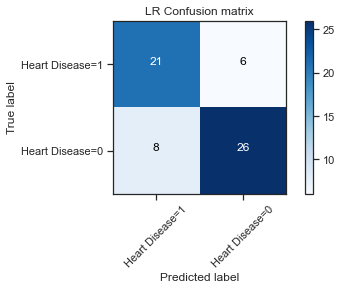

In [81]:
# Compute confusion matrix
LR_cnf_matrix = confusion_matrix(y_test, tree_grid.predict(X_test), labels=[1,0])
np.set_printoptions(precision=2)


# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(LR_cnf_matrix, classes=['Heart Disease=1','Heart Disease=0'], normalize= False, title='Confusion matrix for Decision Tree')

### Ploting the decision tree
* The best parameters: depth = 8, min_samples_split = 3, min_samples_leaf = 2

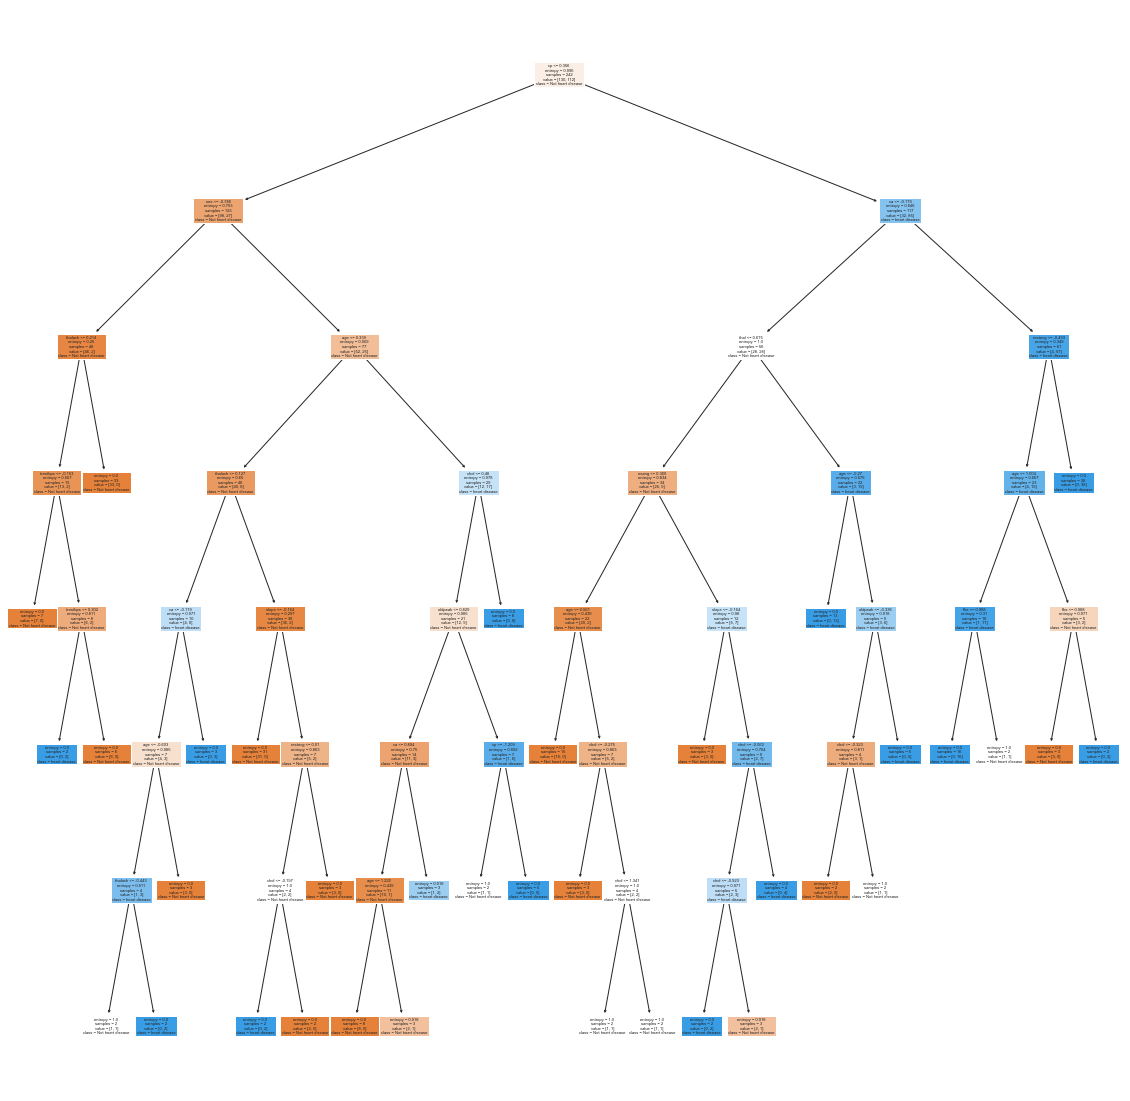

In [67]:
model = tree_grid.best_estimator_
model.fit(X_train, y_train)
plt.figure(figsize=(20,20))
plot_tree(model,feature_names=df.columns,class_names=['Not heart disease','heart disease'], filled=True)
plt.show()

### Feature Importance
* The feature importance plot shows that the columns _cp_, _age_, _ca_ contribute the most in the Random Forest classifier, which are the variables that correlate with _target_

In [82]:
def plot_feature_importance(model):
    '''
    Draw a bar chart to visualize the importance of different features in model
    '''
    importances = list(model.feature_importances_) 
    feature_list = df.columns
    feature_importances = [(feature, round(importance, 3)) for feature, importance in zip(feature_list, importances)]
    feature_importances = sorted(feature_importances, key =lambda x:x[1],reverse = True)
    features = [feature_importances[i][0] for i in range(len(feature_importances))]
    importances = [feature_importances[i][1] for i in range(len(feature_importances))]
    #图像绘制
    fig,ax = plt.subplots(1,1,figsize = (12,10)) 
    b = ax.barh(range(len(features)),importances)
    plt.title('Feature importances of {}'.format(model))
    i = 0
    #添加数据标签
    for rect in b:
        w=rect.get_width()
        ax.text(w,rect.get_y()+rect.get_height()/2,importances[i],ha='left',va='center')
        i += 1
    #设置y坐标
    ax.set_yticks(range(len(features)))
    ax.set_yticklabels(features)
    plt.gca().invert_yaxis()

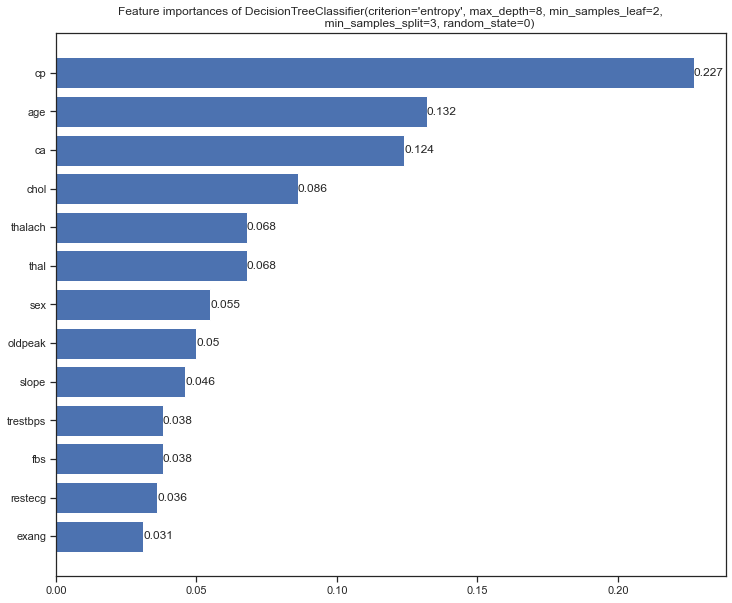

In [83]:
plot_feature_importance(model)

### Post-pruning techiniques
* Post-pruning is based on Minimal Cost-Complexity Pruning
* The complexity parameter $\alpha$ is used to define the cost-complexity measure of a given tree

In [103]:
path = model.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities
ccp_alphas

array([0.  , 0.  , 0.  , 0.  , 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01,
       0.01, 0.01, 0.01, 0.01, 0.02, 0.02, 0.03, 0.04, 0.05, 0.13])

### Ploting the accuracy of different $\alpha$ from 0 to 0.13
* We can see that when $\alpha$ = 0.03, the testing accuracy becomes the highest
* Therefore, we train a decision tree model with $\alpha$ = 0.03, and it will be the optimal one

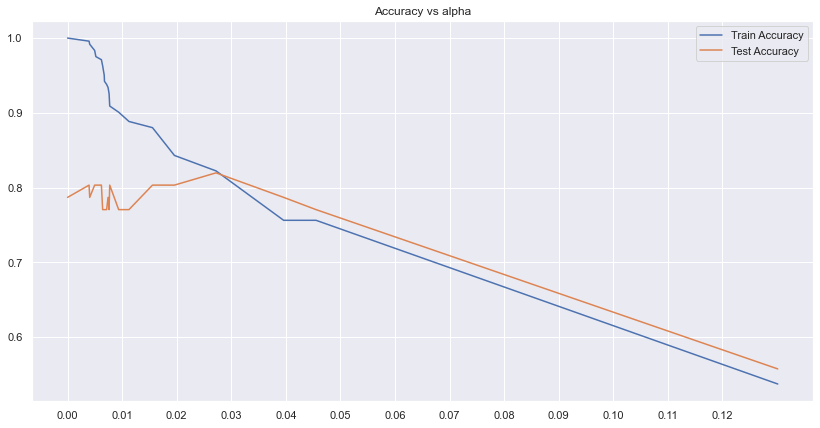

In [118]:
accuracy_train, accuracy_test = [], []
for i in ccp_alphas:
    tree = DecisionTreeClassifier(ccp_alpha=i)
    tree.fit(X_train, y_train)
    accuracy_train.append(accuracy_score(tree.predict(X_train), y_train))
    accuracy_test.append(accuracy_score(tree.predict(X_test), y_test))
sns.set()
plt.figure(figsize=(14,7))
sns.lineplot(y=accuracy_train, x=ccp_alphas, label="Train Accuracy")
sns.lineplot(y=accuracy_test, x=ccp_alphas, label="Test Accuracy")
plt.xticks(ticks=np.arange(0.00, 0.13, 0.01))
plt.title('Accuracy vs alpha')
plt.show()

After post-pruning by Cost-Complexity Pruning, the accuracy score goes to 81.96%:

In [ ]:
model = DecisionTreeClassifier(random_state=0,ccp_alpha=0.03)
model.fit(X_train,y_train)

In [125]:
print("Training accuracy: ", model.score(X_train, y_train))
print("Cross Validation accuracy: ", np.mean(cross_val_score(model, X_train, y_train, cv=5)))
print("Testing accuracy: ", model.score(X_test, y_test))

Training accuracy:  0.8223140495867769
Cross Validation accuracy:  0.735969387755102
Testing accuracy:  0.819672131147541


### Confusion matrix
* Training accuracy, testing accuracy and confusion matrix all shows that our Minimal Cost-Complexity pruning solves the overfitting problem, and now the decision tree fits well

Confusion matrix, without normalization
[[19  8]
 [ 3 31]]


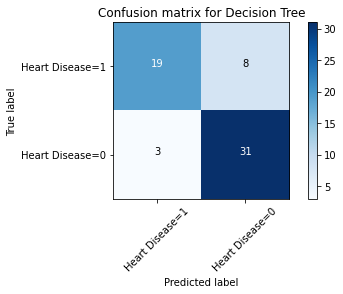

In [133]:
# Compute confusion matrix
LR_cnf_matrix = confusion_matrix(y_test, model.predict(X_test), labels=[1,0])
np.set_printoptions(precision=2)
sns.reset_orig()
# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(LR_cnf_matrix, classes=['Heart Disease=1','Heart Disease=0'], normalize= False, title='Confusion matrix for Decision Tree')

### Ploting the decision tree
* After Cost-Complexity Pruning, the tree only contains 7 nodes, and its depth is only 4
* Now only the important columns _cp_, _ca_, _thal_ plays a role in the decision tree, so the computation complexity is extremely reduced

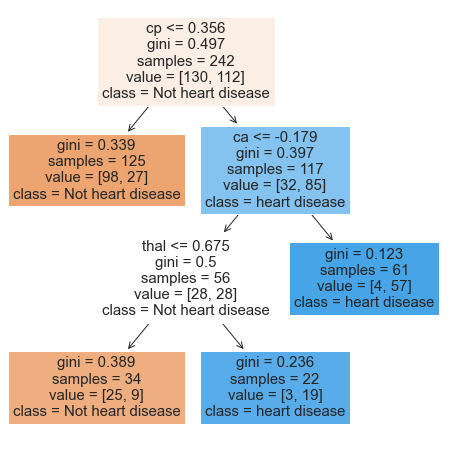

In [97]:
plt.figure(figsize=(8,8))
plot_tree(model,feature_names=df.columns,class_names=['Not heart disease','heart disease'], filled=True)
plt.show()

## 2.3 Random Forest Classifier
* We use _GridSearchCV_ to exhaustively search over specified parameter values for the estimator
* Plot the feature importances to show which features performs the vital roles when fitting random forest
* Then we plot accuracy score when the _max_depth_ varies from 2 to 8, and find the optimal depth for our classifier

With the help of _GridSearchCV_, our accuracy score reaches 80.32%, but seems overfitted:

In [237]:
param_grid = [
    {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
]

scorer = "accuracy"

forest_clf = RandomForestClassifier()
forest_grid = RandomizedSearchCV(estimator = forest_clf, param_distributions = param_grid, cv = 5, scoring = scorer, n_jobs = -1)
forest_grid.fit(X_train, y_train)

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-1,
                   param_distributions=[{'max_features': [2, 4, 6, 8],
                                         'n_estimators': [3, 10, 30]},
                                        {'bootstrap': [False],
                                         'max_features': [2, 3, 4],
                                         'n_estimators': [3, 10]}],
                   scoring='accuracy')

In [242]:
print("The best parameters are: ", forest_grid.best_params_)
print("Training accuracy: ", forest_grid.score(X_train, y_train))
print("Cross Validation accuracy: ", forest_grid.best_score_)
print("Testing accuracy: ", forest_grid.score(X_test, y_test))

The best parameters are:  {'n_estimators': 10, 'max_features': 2}
Training accuracy:  0.987603305785124
Cross Validation accuracy:  0.8223639455782313
Testing accuracy:  0.8032786885245902


### Confusion matrix
* Training accuracy, testing accuracy and confusion matrix shows that our random forest overfits on the training set
* This is mainly due to the _max_depth_ of the tree, and we need to search for the optimal depth of our classifier

Confusion matrix, without normalization
[[19  8]
 [ 4 30]]


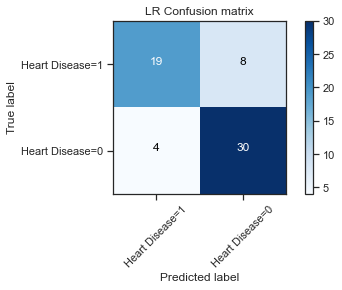

In [44]:
# Compute confusion matrix
LR_cnf_matrix = confusion_matrix(y_test, forest_grid.predict(X_test), labels=[1,0])
np.set_printoptions(precision=2)


# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(LR_cnf_matrix, classes=['Heart Disease=1','Heart Disease=0'], normalize= False, title='LR Confusion matrix')

### Feature Importance
* The feature importance plot shows that the columns _cp_, _oldpeak_, _thalach_ and _ca_ contribute the most in the Random Forest classifier, which are the variables that correlate with _target_

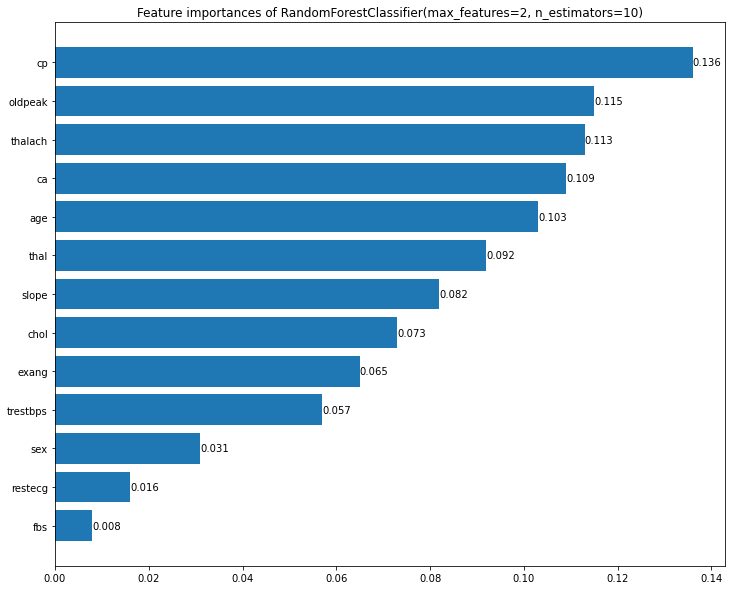

In [241]:
model = forest_grid.best_estimator_
model.fit(X_train, y_train)
plot_feature_importance(model)

### Searching for optimal _max_depth_
* By ploting train, cv and test accuracy, we find that the training accuracy goes higher as the _max_depth_ grows, but cv accuracy and test accuracy decrease after a while
* According to the plot, the optimal _max_depth_ is 3

In [253]:
results_rf = []
for depth in range(2, 8):
    clf = RandomForestClassifier(max_depth=depth)
    clf.fit(X_train, y_train)
    train_acc = clf.score(X_train, y_train)
    test_acc = clf.score(X_test, y_test)
    cv_acc = np.mean(cross_val_score(clf, X_train, y_train, cv=5))
    results_rf.append([depth, train_acc, test_acc, cv_acc])
results_rf = pd.DataFrame(
    data=results_rf,
    columns=['depth', 'train accuracy', 'test accuracy', 'cv accuracy'],
)
results_rf = pd.melt(
    results_rf,
    id_vars=['depth'],
    var_name='type',
    value_name='accuracy'
)

Text(0.5, 1.0, 'Random Forest')

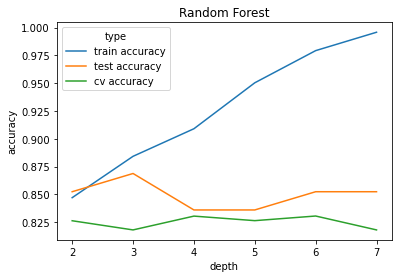

In [254]:
sns.lineplot(
    x='depth',
    y='accuracy',
    hue='type',
    data=results_rf,
)
plt.title('Random Forest')

After searching for the best _max_depth_, the accuracy score goes to 86.89%:

In [359]:
forest_clf = RandomForestClassifier(max_depth = 6, random_state=2)
forest_clf.fit(X_train, y_train)
print("Training accuracy: ", forest_clf.score(X_train, y_train))
print("Cross Validation accuracy: ", np.mean(cross_val_score(forest_clf, X_train, y_train, cv=5)))
print("Testing accuracy: ", forest_clf.score(X_test, y_test))

Training accuracy:  0.9710743801652892
Cross Validation accuracy:  0.8221938775510204
Testing accuracy:  0.8688524590163934


## 2.4 Neural Network
* We use _Tensorflow.keras_ to design and train our neural network model
* Design 2 difference networks with different depth, to find **whether depth is important for neural networks**

### Split the training set and validation set
* Validation set can be used while training to test the accuracy of neural network, avoiding overfitting

In [338]:
X_train1, X_validation, y_train1, y_validation = train_test_split(X_train, y_train, test_size = 0.25, random_state = 2)
print('Train set:', X_train1.shape, y_train1.shape)
print('Validation set:', X_validation.shape, y_validation.shape)

Train set: (181, 13) (181,)
Validation set: (61, 13) (61,)


### Training shallow network
* We use 4 layers, including 1 input layer, 2 hidden layers and 1 output layer in this network
* Loss function: binary cross entropy; Optimizer: Adam

In [339]:
model = Sequential()
model.add(Dense(7, activation='relu', input_dim=13)) 
model.add(Dense(3, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [340]:
model.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_39 (Dense)             (None, 7)                 98        
_________________________________________________________________
dense_40 (Dense)             (None, 3)                 24        
_________________________________________________________________
dense_41 (Dense)             (None, 1)                 4         
Total params: 126
Trainable params: 126
Non-trainable params: 0
_________________________________________________________________


In [341]:
model.compile(
    loss='binary_crossentropy',
    optimizer=Adam(),
    metrics=['accuracy'],
)

Initial weights and train our network for 30 epochs, setting the batch size to 16:

In [342]:
initial_weights = model.get_weights()  # We save initial weights for later use

In [343]:
history = model.fit(
    x=X_train1,
    y=y_train1,
    batch_size=16,
    epochs=30,
    validation_data=(X_validation, y_validation),
    verbose=2,
)

Epoch 1/30
12/12 - 0s - loss: 0.6899 - accuracy: 0.5746 - val_loss: 0.7728 - val_accuracy: 0.5246
Epoch 2/30
12/12 - 0s - loss: 0.6556 - accuracy: 0.5912 - val_loss: 0.7347 - val_accuracy: 0.4918
Epoch 3/30
12/12 - 0s - loss: 0.6283 - accuracy: 0.6188 - val_loss: 0.7058 - val_accuracy: 0.5082
Epoch 4/30
12/12 - 0s - loss: 0.6087 - accuracy: 0.6630 - val_loss: 0.6821 - val_accuracy: 0.5246
Epoch 5/30
12/12 - 0s - loss: 0.5928 - accuracy: 0.6906 - val_loss: 0.6654 - val_accuracy: 0.5410
Epoch 6/30
12/12 - 0s - loss: 0.5812 - accuracy: 0.7127 - val_loss: 0.6529 - val_accuracy: 0.5410
Epoch 7/30
12/12 - 0s - loss: 0.5719 - accuracy: 0.7348 - val_loss: 0.6429 - val_accuracy: 0.5902
Epoch 8/30
12/12 - 0s - loss: 0.5638 - accuracy: 0.7293 - val_loss: 0.6346 - val_accuracy: 0.5902
Epoch 9/30
12/12 - 0s - loss: 0.5566 - accuracy: 0.7348 - val_loss: 0.6275 - val_accuracy: 0.5902
Epoch 10/30
12/12 - 0s - loss: 0.5493 - accuracy: 0.7459 - val_loss: 0.6194 - val_accuracy: 0.6066
Epoch 11/30
12/12 -

### Ploting the accuracy and loss in the training history
* We find that the training accuracy and validation accuracy both fluctuate but rise up during the training process, so there is not any overfitting or underfitting issues, and it fit perfectly on our dataset

In [344]:
history_df = pd.DataFrame(history.history)
history_df['epoch'] = history.epoch
history_df.head()

,loss,accuracy,val_loss,val_accuracy,epoch
0,0.689865,0.574586,0.772785,0.524590,0
1,0.655622,0.591160,0.734742,0.491803,1
2,0.628275,0.618785,0.705760,0.508197,2
3,0.608741,0.662983,0.682085,0.524590,3
4,0.592778,0.690608,0.665418,0.540984,4


<AxesSubplot:xlabel='epoch'>

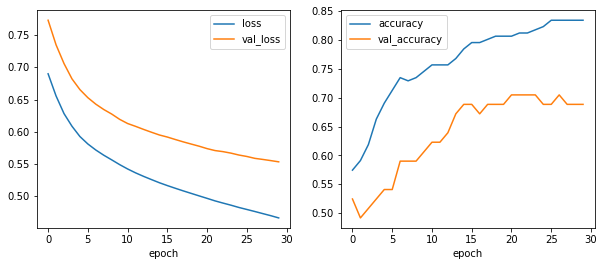

In [345]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))

history_df.plot(x='epoch', y=['loss', 'val_loss'], ax=ax[0])
history_df.plot(x='epoch', y=['accuracy', 'val_accuracy'], ax=ax[1])

The accuracy of shallow neural network is 78.68%:

In [346]:
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)
print('Training accuracy of the model: ', accuracy_score(y_train, y_train_pred.round()))
print('Testing accuracy of the model: ', accuracy_score(y_test, y_pred.round()))

Training accuracy of the model:  0.8057851239669421
Testing accuracy of the model:  0.7868852459016393


Confusion matrix, without normalization
[[19  8]
 [ 5 29]]


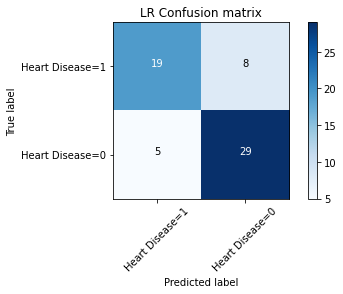

In [347]:
# Compute confusion matrix
LR_cnf_matrix = confusion_matrix(y_test, y_pred.round(), labels=[1,0])
np.set_printoptions(precision=2)


# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(LR_cnf_matrix, classes=['Heart Disease=1','Heart Disease=0'], normalize = False, title='LR Confusion matrix')

## Training deeper network
* We use 5 layers, including 1 input layer, 3 hidden layers and 1 output layer in this network
* Loss function: binary cross entropy; Optimizer: Adam

In [348]:
model = Sequential()
model.add(Dense(7, activation='relu', input_dim=13)) 
model.add(Dense(4, activation='relu')) 
model.add(Dense(2, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_42 (Dense)             (None, 7)                 98        
_________________________________________________________________
dense_43 (Dense)             (None, 4)                 32        
_________________________________________________________________
dense_44 (Dense)             (None, 2)                 10        
_________________________________________________________________
dense_45 (Dense)             (None, 1)                 3         
Total params: 143
Trainable params: 143
Non-trainable params: 0
_________________________________________________________________


In [349]:
model.compile(
    loss='binary_crossentropy',
    optimizer=Adam(),
    metrics=['accuracy'],
)

Initial weights and train our network for 30 epochs, setting the batch size to 16:

In [350]:
initial_weights = model.get_weights()  # We save initial weights for later use
history = model.fit(
    x=X_train1,
    y=y_train1,
    batch_size=16,
    epochs=30,
    validation_data=(X_validation, y_validation),
    verbose=2,
)

Epoch 1/30
12/12 - 0s - loss: 0.6927 - accuracy: 0.5801 - val_loss: 0.7217 - val_accuracy: 0.4590
Epoch 2/30
12/12 - 0s - loss: 0.6843 - accuracy: 0.5635 - val_loss: 0.7128 - val_accuracy: 0.4590
Epoch 3/30
12/12 - 0s - loss: 0.6775 - accuracy: 0.5635 - val_loss: 0.7063 - val_accuracy: 0.4590
Epoch 4/30
12/12 - 0s - loss: 0.6706 - accuracy: 0.5635 - val_loss: 0.6980 - val_accuracy: 0.4590
Epoch 5/30
12/12 - 0s - loss: 0.6624 - accuracy: 0.5635 - val_loss: 0.6907 - val_accuracy: 0.4590
Epoch 6/30
12/12 - 0s - loss: 0.6539 - accuracy: 0.5635 - val_loss: 0.6835 - val_accuracy: 0.4590
Epoch 7/30
12/12 - 0s - loss: 0.6443 - accuracy: 0.5635 - val_loss: 0.6773 - val_accuracy: 0.4590
Epoch 8/30
12/12 - 0s - loss: 0.6341 - accuracy: 0.5635 - val_loss: 0.6705 - val_accuracy: 0.4590
Epoch 9/30
12/12 - 0s - loss: 0.6237 - accuracy: 0.5635 - val_loss: 0.6640 - val_accuracy: 0.4590
Epoch 10/30
12/12 - 0s - loss: 0.6112 - accuracy: 0.5635 - val_loss: 0.6595 - val_accuracy: 0.4590
Epoch 11/30
12/12 -

### Ploting the accuracy and loss in the training history
* We find that the training accuracy and validation accuracy both stay stable in the first a few epochs, facing the bottleneck; then they both fluctuate but rise up during the remaining training process, so there is not any overfitting or underfitting issues, and it fit perfectly on our dataset

In [354]:
history_df = pd.DataFrame(history.history)
history_df['epoch'] = history.epoch
history_df.head()

,loss,accuracy,val_loss,val_accuracy,epoch
0,0.692725,0.580110,0.721733,0.459016,0
1,0.684340,0.563536,0.712773,0.459016,1
2,0.677525,0.563536,0.706258,0.459016,2
3,0.670559,0.563536,0.698048,0.459016,3
4,0.662388,0.563536,0.690713,0.459016,4


<AxesSubplot:xlabel='epoch'>

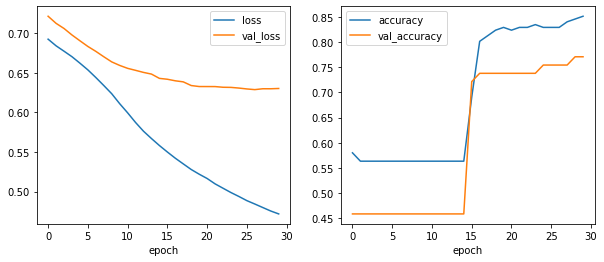

In [355]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))

history_df.plot(x='epoch', y=['loss', 'val_loss'], ax=ax[0])
history_df.plot(x='epoch', y=['accuracy', 'val_accuracy'], ax=ax[1])

The accuracy of deeper neural network is 86.89%, superseding the shallow neural network a bit:

In [352]:
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)
print('Training accuracy of the model: ', accuracy_score(y_train, y_train_pred.round()))
print('Testing accuracy of the model: ', accuracy_score(y_test, y_test_pred.round()))

Training accuracy of the model:  0.8347107438016529
Testing accuracy of the model:  0.8688524590163934


We can conclude that our deeper network performs better on our dataset, so depth plays a vital role on neural networks.

## 2.5 Conclusion
* Support Vector Machine: RBF kernel(gamma=0.001, C=10) performs the best
* Decision Tree: the decision tree after pre-pruning and post-pruning performs the best
* Random Forest: the random forest(n_estimators=10, max_features=2) after searching optimal depth performs the best
* Neural Network: the deeper neural network containing 5 layers performs the best

#### Comparison of performances:
|Unsupervised Model|Training Acc|Cross Validation Acc|Testing Acc|
|:------:|:------:|:------:|:------:|
|Support Vector Machine  |86.36%  |83.45%  |85.25%  |
|Decision Tree  |82.23%  |73.60%  |81.97%  |
|**Random Forest**  |**97.11%**  |**82.22%**  |**86.89%**  |
|**Neural Network**  |**83.47%**  |-  |**86.89%**  |

** The **bolder lines** performs the best in our research

# 3. Unsupervised Learning Tasks

## 3.1 Principal Component Analysis (PCA)

### Show the explained variance of PCA
* We choose the number of components prior to the elbow: j = 4, which seems to be the correct number of components, and we would prove it later

In [142]:
pca = PCA()
pca.fit(X_train)

PCA()

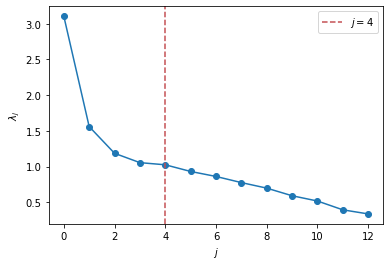

In [137]:
plt.plot(pca.explained_variance_, '-o')
plt.axvline(x=4, c='r', ls='--', label=r'$j=4$')
plt.xlabel(r'$j$')
plt.ylabel(r'$\lambda_j$')
plt.legend()

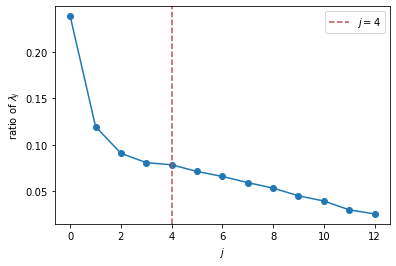

In [138]:
plt.plot(pca.explained_variance_ratio_, '-o')
plt.axvline(x=4, c='r', ls='--', label=r'$j=4$')
plt.xlabel(r'$j$')
plt.ylabel(r'ratio of $\lambda_j$');
plt.legend()

### Show the first two principal components axis

Text(0.5, 1.0, 'Second Principal Component Axis')

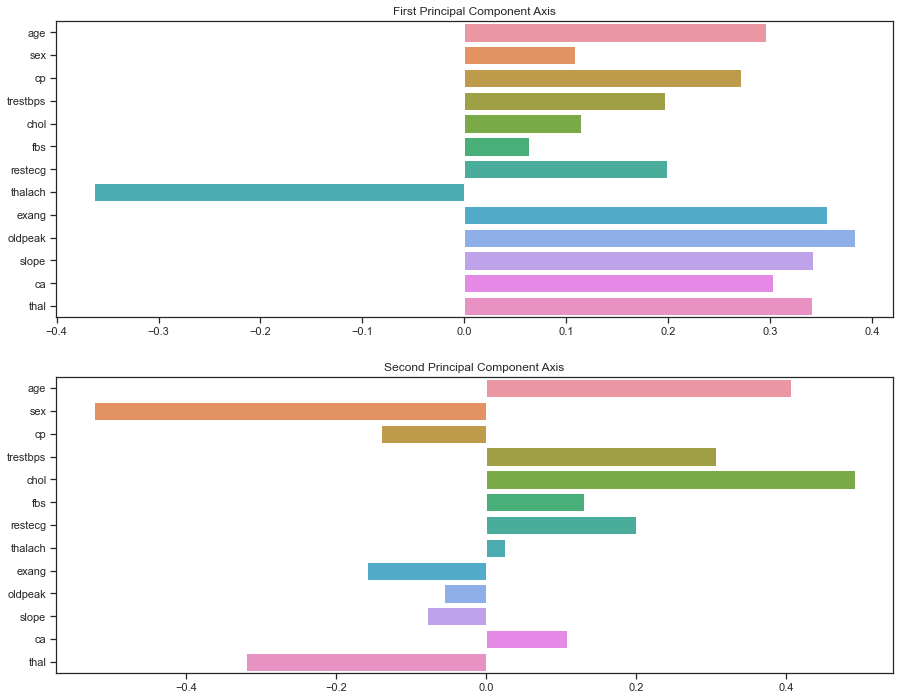

In [67]:
fig, ax = plt.subplots(2, 1, figsize=(15, 12))
sns.barplot(x=pca.components_[0], y=df.columns[:-1], orient='h', ax=ax[0])
sns.barplot(x=pca.components_[1], y=df.columns[:-1], orient='h', ax=ax[1])

ax[0].set_title('First Principal Component Axis')
ax[1].set_title('Second Principal Component Axis')

### PCA : A trade-off between the computation complexity and accuracy
* We train and test our SVM Classifier on both the original dataset and PCA-ed dataset
* The training of SVM on original dataset costs 1.08 second(s), and its accuracy score is 81.97%
* The training of SVM on PCA-ed dataset costs 0.35 second(s), and its accuracy score is 81.97%
* We can see that PCA extremely reduces the computational complexity, and keeps almost the same accuracy score, so it is provides a trade-off between them

#### Original Dataset

In [203]:
start_time = time.time()
param_grid = [
                {'kernel': ['rbf'], 'gamma': [1e-3, 1e-4],
                    'C': [1, 10, 100, 1000]},
                {'kernel': ['linear'], 'C': [1, 10, 100, 1000]}
]

scorer = "accuracy"

svm_clf = SVC()
svm_grid = GridSearchCV(estimator = svm_clf, param_grid = param_grid, cv = 5, scoring = scorer, n_jobs = -1)
svm_grid.fit(X_train, y_train)
print("Cost time:", time.time()-start_time, "second(s)")

Cost time: 1.07100510597229 second(s)


In [205]:
print("The best parameters are: ", svm_grid.best_params_)
print("Training accuracy: ", svm_grid.score(X_train, y_train))
print("Cross Validation accuracy: ", svm_grid.best_score_)
print("Testing accuracy: ", svm_grid.score(X_test, y_test))

The best parameters are:  {'C': 10, 'kernel': 'linear'}
Training accuracy:  0.859504132231405
Cross Validation accuracy:  0.8427721088435375
Testing accuracy:  0.819672131147541


#### PCA-ed Dataset (n_components = 4)
* Accuracy score: 81.97%, superseding the following two results where n_components = 3 or 5
* We prove that the "elbow" value (n_components = 4) is the optimal parameter in our dataset

In [207]:
pca = PCA(n_components = 4)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.fit_transform(X_test)

In [208]:
start_time = time.time()
param_grid = [
                {'kernel': ['rbf'], 'gamma': [1e-3, 1e-4],
                    'C': [1, 10, 100, 1000]},
                {'kernel': ['linear'], 'C': [1, 10, 100, 1000]}
]

scorer = "accuracy"

svm_clf = SVC()
svm_grid_pca = GridSearchCV(estimator = svm_clf, param_grid = param_grid, cv = 5, scoring = scorer, n_jobs = -1)
svm_grid_pca.fit(X_train_pca, y_train)
print("Cost time:", time.time()-start_time, "second(s)")

Cost time: 0.3104877471923828 second(s)


In [209]:
print("The best parameters are: ", svm_grid_pca.best_params_)
print("Training accuracy: ", svm_grid_pca.score(X_train_pca, y_train))
print("Cross Validation accuracy: ", svm_grid_pca.best_score_)
print("Testing accuracy: ", svm_grid_pca.score(X_test_pca, y_test))

The best parameters are:  {'C': 10, 'gamma': 0.001, 'kernel': 'rbf'}
Training accuracy:  0.8388429752066116
Cross Validation accuracy:  0.8385204081632652
Testing accuracy:  0.819672131147541


#### PCA-ed Dataset (n_components = 5)
* Accuracy score: 80.33%

In [210]:
pca = PCA(n_components = 5)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.fit_transform(X_test)

In [211]:
start_time = time.time()
param_grid = [
                {'kernel': ['rbf'], 'gamma': [1e-3, 1e-4],
                    'C': [1, 10, 100, 1000]},
                {'kernel': ['linear'], 'C': [1, 10, 100, 1000]}
]

scorer = "accuracy"

svm_clf = SVC()
svm_grid_pca = GridSearchCV(estimator = svm_clf, param_grid = param_grid, cv = 5, scoring = scorer, n_jobs = -1)
svm_grid_pca.fit(X_train_pca, y_train)

GridSearchCV(cv=5, estimator=SVC(), n_jobs=-1,
             param_grid=[{'C': [1, 10, 100, 1000], 'gamma': [0.001, 0.0001],
                          'kernel': ['rbf']},
                         {'C': [1, 10, 100, 1000], 'kernel': ['linear']}],
             scoring='accuracy')

In [212]:
print("The best parameters are: ", svm_grid_pca.best_params_)
print("Training accuracy: ", svm_grid_pca.score(X_train_pca, y_train))
print("Cross Validation accuracy: ", svm_grid_pca.best_score_)
print("Testing accuracy: ", svm_grid_pca.score(X_test_pca, y_test))

The best parameters are:  {'C': 100, 'gamma': 0.001, 'kernel': 'rbf'}
Training accuracy:  0.8429752066115702
Cross Validation accuracy:  0.8303571428571429
Testing accuracy:  0.8032786885245902


#### PCA-ed Dataset (n_components = 3)
* Accuracy score: 72.13%

In [213]:
pca = PCA(n_components = 3)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.fit_transform(X_test)

In [214]:
start_time = time.time()
param_grid = [
                {'kernel': ['rbf'], 'gamma': [1e-3, 1e-4],
                    'C': [1, 10, 100, 1000]},
                {'kernel': ['linear'], 'C': [1, 10, 100, 1000]}
]

scorer = "accuracy"

svm_clf = SVC()
svm_grid_pca = GridSearchCV(estimator = svm_clf, param_grid = param_grid, cv = 5, scoring = scorer, n_jobs = -1)
svm_grid_pca.fit(X_train_pca, y_train)

GridSearchCV(cv=5, estimator=SVC(), n_jobs=-1,
             param_grid=[{'C': [1, 10, 100, 1000], 'gamma': [0.001, 0.0001],
                          'kernel': ['rbf']},
                         {'C': [1, 10, 100, 1000], 'kernel': ['linear']}],
             scoring='accuracy')

In [215]:
print("The best parameters are: ", svm_grid_pca.best_params_)
print("Training accuracy: ", svm_grid_pca.score(X_train_pca, y_train))
print("Cross Validation accuracy: ", svm_grid_pca.best_score_)
print("Testing accuracy: ", svm_grid_pca.score(X_test_pca, y_test))

The best parameters are:  {'C': 1000, 'gamma': 0.001, 'kernel': 'rbf'}
Training accuracy:  0.8429752066115702
Cross Validation accuracy:  0.8341836734693878
Testing accuracy:  0.7213114754098361


## 3.2 Kernel PCA
* Kernel PCA is a non-linear dimensionality reduction through the use of kernels
* There are a couple of kernels for use, including linear, polynomial and rbf kernel

In [199]:
kernel_pca = KernelPCA()
kernel_pca.fit(X_train)
kernel_pca.lambdas_

array([748.42, 375.87, 285.71, 254.17, 246.93, 224.44, 207.52, 186.86,
       168.12, 142.43, 124.61,  94.89,  81.09])

According to the $\lambda$, we choose n_components = 6, and the RBF kernel for the kernel PCA:

In [200]:
pca = KernelPCA(n_components = 6, kernel="rbf", gamma=0.01)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.fit_transform(X_test)

#### Kernel PCA-ed Dataset (n_components = 6, kernel = rbf)
* Accuracy score: 83.61%
* We can see that the kernel PCA performs perfectly on our dataset - it makes the accuracy higher by dimension reduction, and also reduces the computation complexity of SVM training
* In conclusion, Kernel PCA supersedes PCA on our dataset

In [216]:
start_time = time.time()
param_grid = [
                {'kernel': ['rbf'], 'gamma': [1e-3, 1e-4],
                    'C': [1, 10, 100, 1000]},
                {'kernel': ['linear'], 'C': [1, 10, 100, 1000]}
]

scorer = "accuracy"

svm_clf = SVC()
svm_grid_pca = GridSearchCV(estimator = svm_clf, param_grid = param_grid, cv = 5, scoring = scorer, n_jobs = -1)
svm_grid_pca.fit(X_train_pca, y_train)
print("Cost time:", time.time()-start_time, "second(s)")

Cost time: 0.1381206512451172 second(s)


In [202]:
print("The best parameters are: ", svm_grid_pca.best_params_)
print("Training accuracy: ", svm_grid_pca.score(X_train_pca, y_train))
print("Cross Validation accuracy: ", svm_grid_pca.best_score_)
print("Testing accuracy: ", svm_grid_pca.score(X_test_pca, y_test))

The best parameters are:  {'C': 10, 'kernel': 'linear'}
Training accuracy:  0.8347107438016529
Cross Validation accuracy:  0.8262755102040817
Testing accuracy:  0.8360655737704918


## 3.3 K-Means
* We fit our KMeans model on the training set, for two different methods for initialization:
>- "k-means++": selects initial cluster centers for k-mean clustering in a smart way to speed up convergence.
>- "random": choose n_clusters observations (rows) at random from data for the initial centroids.
* By comparing the performances of two models, we can see that k-means++ initialization make the convergence more quickly, and its accuracy supersedes the random initialization a bit
* We can say that k-means++ initialization performs better than random initialization, and that's why it is the default method for initialization

In [227]:
start_time = time.time()
kmeans = KMeans(n_clusters=2, init = "k-means++",random_state=12)
clusters = kmeans.fit_predict(X_train)
# clusters = [1 if cluster == 0 else 0 for cluster in clusters]
print(accuracy_score(y_train, clusters))
print("Cost time:", time.time()-start_time, "second(s)")

0.8264462809917356
Cost time: 0.011539697647094727 second(s)


In [228]:
start_time = time.time()
kmeans = KMeans(n_clusters=2, init = "random", random_state=12)
clusters = kmeans.fit_predict(X_train)
clusters = [1 if cluster == 0 else 0 for cluster in clusters]
print(accuracy_score(y_train, clusters))
print("Cost time:", time.time()-start_time, "second(s)")

0.8223140495867769
Cost time: 0.011883258819580078 second(s)


In [100]:
kmeans.cluster_centers_

array([[ 0.41,  0.29,  0.65,  0.2 ,  0.15,  0.15,  0.21, -0.74,  0.78,
         0.73,  0.61,  0.61,  0.68],
       [-0.24, -0.17, -0.38, -0.12, -0.09, -0.09, -0.12,  0.44, -0.46,
        -0.44, -0.36, -0.37, -0.4 ]])

By ploting the Sum Squared Error (SSE) when choosing different cluster numbers, we choose the "elbow" value - **2 clusters**, and that is our optimal cluster number for K-Means:

In [173]:
SSE = []
max_cluster = 10
for cluster in range(1, max_cluster):
        
    kmeans = KMeans(n_clusters = cluster, init = 'k-means++', random_state = 999)
    kmeans.fit(X_train)
    SSE.append(kmeans.inertia_)
        
df_plot = pd.DataFrame({'Cluster': range(1, max_cluster), 'SSE': SSE})

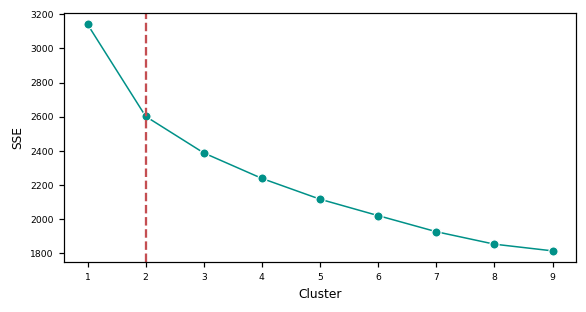

In [217]:
with plt.rc_context(rc = {'figure.dpi': 110, 'axes.labelsize': 8, 
                          'xtick.labelsize': 6, 'ytick.labelsize': 6}):
    
    fig_8, ax_8 = plt.subplots(1, 1, figsize = (6, 3))

    sns.lineplot(x = df_plot['Cluster'].astype('int64'), 
                 y = df_plot['SSE'], color = '#009188', 
                 marker = 'o', linewidth = 1)
    plt.axvline(x=2, c='r', ls='--', label=r'$j=2$')
    plt.xticks(range(1, 10))
          
    plt.show()

## 3.4 Gaussian Mixture Model
* We fit our GMM model on the training set, for two different types of covariance parameters:
>- "full": each component has its own general covariance matrix
>- "spherical": each component has its own single variance
* By comparing the performances of two models, we can see that full covariance performs better, since its accuracy supersedes spherical covariance a bit, and that's why it is the default covariance type

In [122]:
gmm = GaussianMixture(n_components=2, covariance_type='full')
gmm.fit(X_train)

GaussianMixture(n_components=2)

In [123]:
y_pred = gmm.predict(X_train)
y_prob = gmm.predict_proba(X_train)
accuracy_score(y_pred, y_train)

0.7272727272727273

In [124]:
gmm = GaussianMixture(n_components=2, covariance_type='spherical')
gmm.fit(X_train)

GaussianMixture(covariance_type='spherical', n_components=2)

In [125]:
y_pred = gmm.predict(X_train)
y_prob = gmm.predict_proba(X_train)
accuracy_score(y_pred, y_train)

0.7148760330578512

### Visualizing the clustering results
* Visualize the clustering results by performing PCA on the training sets, reducing their dimension to 2, and plot them in different colors as they belong to different clusters
* We can see that both of the two algorithms cluster all the data by the distance, but GMM seems a **soft version** of K-Means, since the margin between two clusters seems not so obvious when clustering by GMM, while the K-Means produces a clear margin between them

Text(0.5, 0.98, 'Comparison of the clustering results')

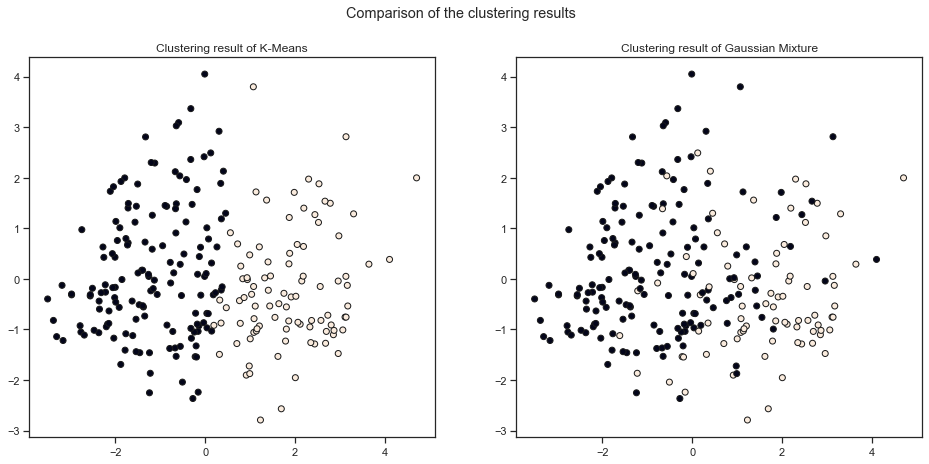

In [157]:
pca = PCA(n_components = 2)
X_train_visualization = pca.fit_transform(X_train)
fig, axes = plt.subplots(1, 2, figsize=(16, 7))  # type: plt.Figure, np.ndarray
ax0, ax1 = axes.ravel()
ax0.scatter(x=X_train_visualization[:, 0], y=X_train_visualization[:, 1], c=clusters, edgecolors='k')
ax0.set_title('Clustering result of K-Means')
ax1.scatter(x=X_train_visualization[:, 0], y=X_train_visualization[:, 1], c=y_pred, edgecolors='k')
ax1.set_title('Clustering result of Gaussian Mixture')
fig.suptitle('Comparison of the clustering results')

## 3.5 Conclusion


#### Comparison of Dimension Reduction Models:
|Dimension Reduction Model|Acc|Cost Time|
|:------:|:------:|:------:|
|SVM  |81.97%  |1.07s  |
|SVM with PCA(n_component=3)  |72.13%  |-  |
|SVM with PCA(n_component=4)  |81.97%  |0.31s |
|SVM with PCA(n_component=5)  |80.33%  |-  |
|**SVM with Kernel PCA**  |**82.23%**  |**0.14s**  |

#### Comparison of Clustering Models:
|Clustering Model|Acc|
|:------:|:------:|
|**K-Means**  |**82.64%**  |
|GMM  |72.72%  ||

** The **bolder lines** performs the best in our research